Caltech-UCSD Birds-200-2011 is an extended version of the CUB-200-dataset, with roughly double the number of images per class and new part location annotations.

This Dataset containt 200 species of bird.

In [0]:
fast_run = False
image_width = 224
image_height = 224
image_channels = 3

## Downloading the Data and preparing the Data

In [2]:
!wget http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz

--2020-04-18 03:33:34--  http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1150585339 (1.1G) [application/x-tar]
Saving to: ‘CUB_200_2011.tgz’

CUB_200_2011.tgz    100%[===================>]   1.07G  3.45MB/s    in 7m 11s  

2020-04-18 03:40:45 (2.55 MB/s) - ‘CUB_200_2011.tgz’ saved [1150585339/1150585339]



In [0]:
import tarfile
filename = "CUB_200_2011.tgz"
taf = tarfile.open(filename)
taf.extractall('/content/')

In [4]:
#for more free space we delete the .tgz file
!rm --y CUB_200_2011.tgz

rm: unrecognized option '--y'
Try 'rm --help' for more information.


# Train Test Splitting
thank you from nomow answer in stack overflow

In [0]:
import shutil
import os
import numpy as np
import argparse

In [0]:
def get_files_from_folder(path):
  files = os.listdir(path)
  return np.asarray(files)

In [0]:
def split_image_dataset(path_to_data, path_to_test_data,train_ratio):
  _, dirs, _ = next(os.walk(path_to_data))

  # calculates how many train data per class
  data_counter_per_class = np.zeros((len(dirs)))
  for i in range(len(dirs)):
    path = os.path.join(path_to_data, dirs[i])
    files = get_files_from_folder(path)
    data_counter_per_class[i] = len(files)
    test_counter = np.round(data_counter_per_class * (1 - train_ratio))

    # transfers files
  for i in range(len(dirs)):
    path_to_original = os.path.join(path_to_data, dirs[i])
    path_to_save = os.path.join(path_to_test_data, dirs[i])

        #creates dir
    if not os.path.exists(path_to_save):
      os.makedirs(path_to_save)
    files = get_files_from_folder(path_to_original)
        # moves data
    for j in range(int(test_counter[i])):
        dst = os.path.join(path_to_save, files[j])
        src = os.path.join(path_to_original, files[j])
        shutil.move(src, dst)

In [0]:
os.makedirs('./test')

In [0]:
split_image_dataset('./CUB_200_2011/images', './test', 0.85)

In [0]:
train_path = './CUB_200_2011/images/'
test_path = './test'

In [0]:
filenames = os.listdir(train_path)
categories = []

# Image preprocessing using ImageDatagen

In [12]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Add, Input, ZeroPadding2D, AveragePooling2D
from keras.initializers import glorot_uniform
import matplotlib.pyplot as plt
import random

Using TensorFlow backend.


In [13]:
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size = 32,
    class_mode = 'categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224,224),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 10011 images belonging to 200 classes.
Found 1777 images belonging to 200 classes.


# Architechture Neural Network
We're gonna Use CNN \
ResNet50 (Residual Neural Network 50 Layer)

In [0]:
def identity_block(X,f,filters, stage, block):
  #defining name basis
  conv_name_base = 'res' +str(stage)+block+'_branch'
  bn_name_base = 'bn' +str(stage)+block+'_branch'

  #Retrive Filters
  F1,F2,F3 = filters

  X_shortcut = X

  X = Conv2D(filters=F1, kernel_size=(1,1), strides = (1,1), padding='valid', name = conv_name_base+'2a',kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base+'2a')(X)
  X = Activation('relu')(X)

  X = Conv2D(filters=F2, kernel_size=(f,f), strides = (1,1), padding='same', name = conv_name_base+'2b',kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base+'2b')(X)
  X = Activation('relu')(X)

  X = Conv2D(filters=F3, kernel_size=(1,1), strides = (1,1), padding='valid', name = conv_name_base+'2c',kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base+'2c')(X)
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)

  return X

In [0]:
def convolutional_block(X, f, filters, stage, block, s=2):
  conv_name_base = 'res' +str(stage)+block+'_branch'
  bn_name_base = 'bn' +str(stage)+block+'_branch'

  F1,F2,F3 = filters

  X_shortcut = X

  X = Conv2D(filters=F1, kernel_size=(1,1), strides = (s,s), name = conv_name_base+'2a',kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base+'2a')(X)
  X = Activation('relu')(X)

  X = Conv2D(filters=F2, kernel_size=(f,f), strides = (1,1),padding='same', name = conv_name_base+'2b',kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base+'2b')(X)
  X = Activation('relu')(X)

  X = Conv2D(filters=F3, kernel_size=(1,1), strides = (1,1),padding='valid', name = conv_name_base+'2c',kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base+'2c')(X)

  X_shortcut = Conv2D(filters=F3, kernel_size=(1,1), strides = (s,s), name = conv_name_base+'1',kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
  X_shortcut = BatchNormalization(axis = 3, name = bn_name_base+'1')(X_shortcut)
  X = Add() ([X, X_shortcut])
  X = Activation('relu')(X)

  return X

In [0]:
def ResNet50(input_shape = (224,224,3), classes = 200):
  X_input = Input(input_shape)

  #Zero padding
  X = ZeroPadding2D((3,3))(X_input)

  #stage 1
  X = Conv2D(64,(7,7),strides=(2,2), name = 'conv1', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name = 'bn_conv1')(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3,3), strides=(2,2))(X)

  #stage 2
  X = convolutional_block(X, f=3, filters=[64, 64, 256], stage = 2, block='a', s=1)
  X = identity_block(X, 3, [64,64,256], stage=2, block='b')
  X = identity_block(X,3,[64,64,256], stage = 2, block = 'c')

  #stage 3
  X = convolutional_block(X, f=3, filters=[128, 128, 512], stage = 3, block='a', s=2)
  X = identity_block(X, 3, filters=[128, 128, 512], stage=3, block='b')
  X = identity_block(X,3,filters=[128, 128, 512], stage = 3, block = 'c')
  X = identity_block(X,3,filters=[128, 128, 512], stage = 3, block = 'd')

  #stage 4
  X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage = 4, block='a', s=2)
  X = identity_block(X, 3, filters=[256, 256, 1024], stage=4, block='b')
  X = identity_block(X,3,filters=[256, 256, 1024], stage = 4, block = 'c')
  X = identity_block(X,3,filters=[256, 256, 1024], stage = 4, block = 'd')
  X = identity_block(X,3,filters=[256, 256, 1024], stage = 4, block = 'f')

  #stage 5
  X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage = 5, block='a', s=2)
  X = identity_block(X, 3, filters=[512, 512, 2048], stage=5, block='b')
  X = identity_block(X,3,filters=[512, 512, 2048], stage = 5, block = 'c')

  X = AveragePooling2D((2,2), name = 'avg_pool')(X)

  X = Flatten()(X)
  X = Dense(classes, activation='softmax', name='fc'+str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

  model = Model(inputs = X_input, outputs = X, name='ResNet50')

  return model

In [0]:
model = ResNet50(input_shape = (224,224,3), classes = 200)

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

# ReduceLROPlateau
so when the training is happening and the loss is not change for some iteration the learning rate will decrease

In [0]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [0]:
earlystopping = EarlyStopping(patience=10)

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2,verbose=1,factor=0.5,min_lr=0.00001)

In [0]:
callbacks=[earlystopping,learning_rate_reduction]

# Training the model

In [23]:
history = model.fit_generator(train_generator,epochs=100, validation_data=test_generator, validation_steps=10, callbacks=callbacks)

Epoch 1/100
313/313 [==============================] - 190s 608ms/step - loss: 5.9770 - accuracy: 0.0091 - val_loss: 5.2812 - val_accuracy: 0.0094
Epoch 2/100
313/313 [==============================] - 169s 541ms/step - loss: 4.9305 - accuracy: 0.0203 - val_loss: 5.0103 - val_accuracy: 0.0312
Epoch 3/100
313/313 [==============================] - 170s 544ms/step - loss: 4.6652 - accuracy: 0.0354 - val_loss: 4.7080 - val_accuracy: 0.0469
Epoch 4/100
313/313 [==============================] - 170s 544ms/step - loss: 4.3607 - accuracy: 0.0647 - val_loss: 4.7380 - val_accuracy: 0.0312
Epoch 5/100
313/313 [==============================] - 170s 544ms/step - loss: 4.1103 - accuracy: 0.0946 - val_loss: 4.4427 - val_accuracy: 0.0781
Epoch 6/100
313/313 [==============================] - 169s 539ms/step - loss: 3.9163 - accuracy: 0.1183 - val_loss: 5.0575 - val_accuracy: 0.0590
Epoch 7/100
313/313 [==============================] - 168s 538ms/step - loss: 3.7078 - accuracy: 0.1470 - val_loss: 4

# Plot The model
The model that I create is overfitting may be is because of the architecture of the neural nets, and need more data for better classification

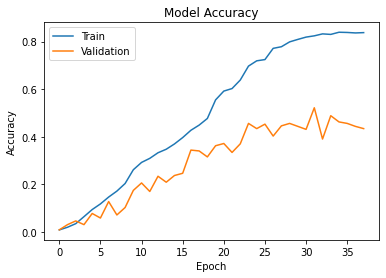

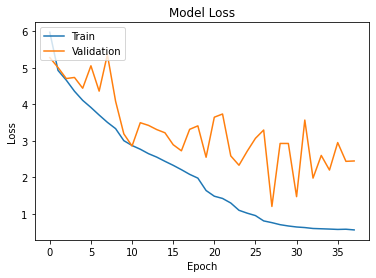

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.show()

In [0]:
model.save('Caltech.h5')